### 1. Your current goal is get familiar with the data you were given, so in this task you should create a notebook that would show all data you have

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)

        File descriptions

    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

    sample_submission.csv - a sample submission file in the correct format.

    items.csv - supplemental information about the items/products.

    item_categories.csv  - supplemental information about the items categories.

    shops.csv- supplemental information about the shops.


        Data fields

    ID - an Id that represents a (Shop, Item) tuple within the test set

    shop_id - unique identifier of a shop

    item_id - unique identifier of a product

    item_category_id - unique identifier of item category

    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

    item_price - current price of an item

    date - date in format dd/mm/yyyy

    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

    item_name - name of item

    shop_name - name of shop

    item_category_name - name of item category


### Extract

In [2]:
import sys
import os

In [3]:
# add data path to sys.path 
data_path = "C:\\Repository\\DS-Intership-data\\raw_data\\"
sys.path.append(data_path)

# pd.read_csv(os.path.join(os.path.dirname(__file__), data.csv)

# initiate dict for data
to_read = {}

# fill to_read
for dir_name, _, files in os.walk(data_path):
    for file in files:
        to_read[file] = dir_name + file

In [4]:
# check to_read
to_read

{'items.csv': 'C:\\Repository\\DS-Intership-data\\raw_data\\items.csv',
 'item_categories.csv': 'C:\\Repository\\DS-Intership-data\\raw_data\\item_categories.csv',
 'sales_train.csv': 'C:\\Repository\\DS-Intership-data\\raw_data\\sales_train.csv',
 'sample_submission.csv': 'C:\\Repository\\DS-Intership-data\\raw_data\\sample_submission.csv',
 'shops.csv': 'C:\\Repository\\DS-Intership-data\\raw_data\\shops.csv',
 'test.csv': 'C:\\Repository\\DS-Intership-data\\raw_data\\test.csv'}

In [5]:
%%time
data = {}
# read data using engine pyarrow for acceleration 
for file, path in to_read.items():
    data[file.split('.')[0]] = pd.read_csv(path, engine="pyarrow")

CPU times: total: 391 ms
Wall time: 318 ms


In [6]:
def info(data):
    data_info = []
    
    for df_name, df in data.items():
        data_info.append( pd.DataFrame(
            data=[(df.isna().sum(0) / len(df)).values, df.nunique().values, df.dtypes, [len(df) for _ in range(len(df.columns))]],
            index=['nan_report', 'unique', 'dtype', 'total'],
            columns= pd.MultiIndex.from_tuples([(col, df_name) for col in df.columns], names=["column_name", "table_name"])
        ))
        
    return pd.concat(data_info, axis=1).transpose().reset_index().set_index(["table_name", "column_name"])

In [7]:
info(data)

nan_report  unique    dtype    total
table_name        column_name                                            
items             item_name                0.00   22170   object    22170
                  item_id                  0.00   22170    int64    22170
                  item_category_id         0.00      84    int64    22170
item_categories   item_category_name       0.00      84   object       84
                  item_category_id         0.00      84    int64       84
sales_train       date                     0.00    1034   object  2935849
                  date_block_num           0.00      34    int64  2935849
                  shop_id                  0.00      60    int64  2935849
                  item_id                  0.00   21807    int64  2935849
                  item_price               0.00   19993  float64  2935849
                  item_cnt_day             0.00     198  float64  2935849
sample_submission ID                       0.00  214200    int64   214200
                  item_cnt_month           0.00       1  float64   214200
shops             shop_name                0.00      60   object       60
                  shop_id                  0.00      60    int64       60
test              ID                       0.00  214200    int64   214200
                  shop_id                  0.00      42    int64   214200
                  item_id                  0.00    5100    int64   214200

1. No Nans
2. String data (shop_name, item_name, item_category_name) has unique values (unique == total)

### Data Quality Check layer

        1) Outliers
        2) Poor dynamic all a lot of missing information
        3) Data inconsistency

In [8]:
# create the dataframe with all data include timeseries like day, week, month, year 
all_data = data['sales_train'].merge(data['items'], on='item_id', how='left')\
     .merge(data['item_categories'], on='item_category_id', how='left')\
     .merge(data['shops'], on='shop_id', how='left')\
     .merge(data['test'], on=['item_id', 'shop_id'], how='left').rename(columns={"date_block_num":"month_number"})
all_data['date'] = pd.to_datetime(all_data.date, dayfirst=True)
all_data['day'] = all_data.date.dt.day
all_data['week_number'] = (all_data.date - min(all_data.date)).dt.days // 7
all_data['month'] = all_data.date.dt.month
all_data['year'] = all_data.date.dt.year

In [9]:
all_data.describe()

,date,month_number,shop_id,item_id,item_price,item_cnt_day,item_category_id,ID,day,week_number,month,year
count,2935849,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,1224439.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,2014-04-03 05:44:34.970681344,14.57,33.00,10197.23,890.85,1.24,40.00,95177.27,15.85,64.87,6.25,2013.78
min,2013-01-01 00:00:00,0.00,0.00,0.00,-1.00,-22.00,0.00,0.00,1.00,0.00,1.00,2013.00
25%,2013-08-01 00:00:00,7.00,22.00,4476.00,249.00,1.00,28.00,47841.00,8.00,30.00,3.00,2013.00
50%,2014-03-04 00:00:00,14.00,31.00,9343.00,399.00,1.00,40.00,87160.00,16.00,61.00,6.00,2014.00
75%,2014-12-05 00:00:00,23.00,47.00,15684.00,999.00,1.00,55.00,140099.00,24.00,100.00,9.00,2014.00
max,2015-10-31 00:00:00,33.00,59.00,22169.00,307980.00,2169.00,83.00,214199.00,31.00,147.00,12.00,2015.00
std,NaN,9.42,16.23,6324.30,1729.80,2.62,17.10,56519.74,8.92,40.99,3.54,0.77


1. Delete or replace negative values in item_price and item_cnt_day
2. 75% item_cnt_day == 1 when max is 2169 so need to check for outliers
3. 75% item_price == 999 when max is 307980 so need to check for outliers
4. min time data is 2013-01-01 00:00:00 and max time data is 2015-10-31 00:00:00 so we don't have any coherent time limits

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   month_number        int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   item_name           object        
 7   item_category_id    int64         
 8   item_category_name  object        
 9   shop_name           object        
 10  ID                  float64       
 11  day                 int32         
 12  week_number         int64         
 13  month               int32         
 14  year                int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(5), object(3)
memory usage: 302.4+ MB


### Outliers

In [11]:
%%time
#import dtale
#import dtale.app as dtale_app

#dtale_app.USE_NGROK = True
#dtale.show(all_data)

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
def replace_neg_val(data):
    for df_name, df in data.items():
        float_cols = df.select_dtypes(include=[np.float_])
        for col in float_cols:
            if col == 'item_price':
                mean_price = df[col].mean()
                df[col] = df[col].apply(lambda x: x if x > 0 else mean_price)
            else:
                df[col] = df[col].apply(lambda x: x if x >= 0 else 0)

In [13]:
def calc_treshold(df, prob=0.05):
    return df.mean() / prob

In [14]:
def del_high_outliers(data):
    for df_name, df in data.items():
        float_cols = df.select_dtypes(include=[np.float_])
        for col in float_cols:
            tresh = calc_treshold(df[col], prob=0.05)
            df = df[df[col] < tresh]
        data[df_name] = df

In [15]:
replace_neg_val(data)
del_high_outliers(data)

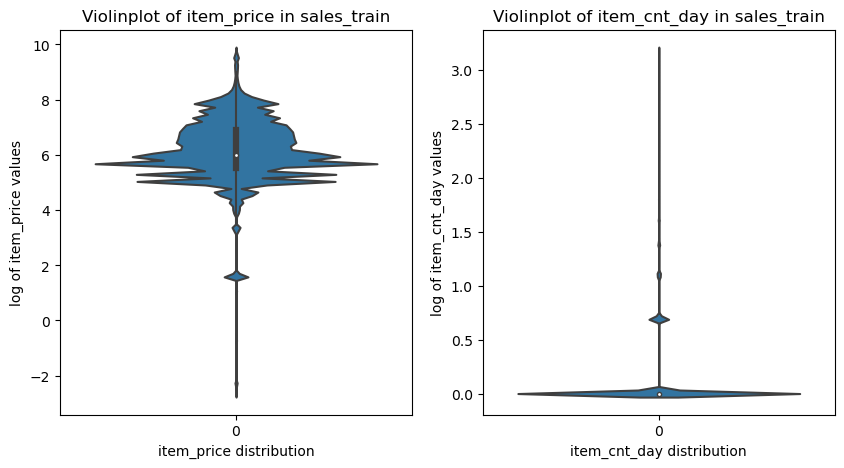

In [16]:
figure, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
# checking for outliers (item_price)
df_ip = data['sales_train'].item_price.apply(lambda x: x if x > 0 else 1)
ax = sns.violinplot(ax = axes[0], data=np.log(df_ip), inner='box')
ax.set(ylabel='log of item_price values', xlabel='item_price distribution')
ax.set(title="Violinplot of item_price in sales_train")
# also need to check (item_cnt_day)
df_icd = data['sales_train'].item_cnt_day.apply(lambda x: x if x > 0 else 1)
ax = sns.violinplot(ax = axes[1], data=np.log(df_icd), inner='box')
ax.set(ylabel='log of item_cnt_day values', xlabel='item_cnt_day distribution')
ax.set(title="Violinplot of item_cnt_day in sales_train")

plt.show()

Coherent time limits

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(<Figure size 1250x510 with 4 Axes>,
 array([<Axes: ylabel='2013'>, <Axes: ylabel='2014'>,
        <Axes: ylabel='2015'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


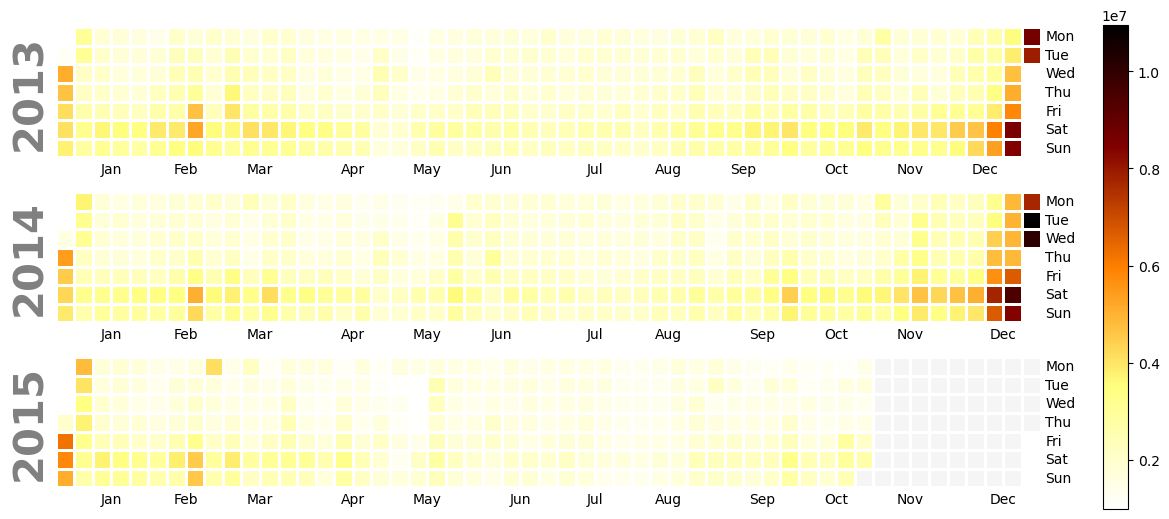

In [59]:
import calplot
from datetime import datetime

df = pd.DataFrame()
df['date'] = pd.to_datetime(data['sales_train']['date'], dayfirst=True)
df['price'] = data['sales_train']['item_price']
df= df.set_index('date')

calplot.calplot(df['price'], edgecolor=None, cmap='afmhot_r')

data intervals correspond to the task

In [18]:
print(data['sales_train'].groupby('date')['item_cnt_day'].count().min(),
      data['sales_train'].groupby('date')['item_cnt_day'].count().max())

1115 9390


No extremely high or low amount of data per day 

Checking for outliers for every month

In [19]:
# date to datetime type
data['sales_train'].date = pd.to_datetime(data['sales_train'].date, dayfirst=True)

In [20]:
# aggregate data by months
df = data['sales_train']
df['year_month']= df.date.dt.to_period('M')
#df.groupby(['year', 'month'])['item_price'].agg('mean')

In [21]:
df.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month
0,2013-01-02,0,59,22154,999.00,1.00,2013-01
1,2013-01-03,0,25,2552,899.00,1.00,2013-01


In [22]:
def outlier_checker(column, z=3):
    outliers = []
    #data standartization
    col = (column - column.mean()) / column.std()
    #calc treshold
    treshold = col.mean() + z * col.std()
    return column[col > treshold].sort_values()

In [23]:
cols_to_check = ['item_price', 'item_cnt_day'] 
outliers = []
for month in df.year_month.unique():
    outliers_per_months = {}
    month_df = df[df.year_month == month]
    for column in cols_to_check:
        outliers_per_months[month] = outlier_checker(month_df[column])
    outliers.append(outliers_per_months)
print(outliers)

[{Period('2013-01', 'M'): 9         3.00
66956     3.00
66539     3.00
66535     3.00
66483     3.00
          ... 
59104    20.00
100498   20.00
95315    21.00
9348     22.00
90954    22.00
Name: item_cnt_day, Length: 2832, dtype: float64}, {Period('2013-02', 'M'): 115849    4.00
156920    4.00
205620    4.00
205604    4.00
157216    4.00
          ... 
170718   23.00
151614   23.00
158378   23.00
175638   24.00
205617   24.00
Name: item_cnt_day, Length: 1686, dtype: float64}, {Period('2013-03', 'M'): 345107    4.00
261167    4.00
309525    4.00
261391    4.00
261392    4.00
          ... 
243675   23.00
238616   23.00
295607   23.00
287940   23.00
295655   24.00
Name: item_cnt_day, Length: 2314, dtype: float64}, {Period('2013-04', 'M'): 345759    4.00
386395    4.00
387108    4.00
388481    4.00
425896    4.00
          ... 
378842   22.00
393688   23.00
432987   23.00
418989   24.00
347435   24.00
Name: item_cnt_day, Length: 1084, dtype: float64}, {Period('2013-05', 'M'): 482870    

### Incosistency

In [24]:
# chekc data for incosistency
#   item_categories -> item_category <- items
#   items -> item_id <- sales_train
#   sales_train -> shop_id <- shops
df_inc1 = data['item_categories'].merge(data['items'], on='item_category_id', how='left')
df_inc2 = data['items'].merge(data['sales_train'], on='item_id', how='left')
df_inc3 = data['sales_train'].merge(data['shops'], on='shop_id', how='left')

In [25]:
print(df_inc1.isna().sum())
print(df_inc2.isna().sum())
print(df_inc3.isna().sum())

item_category_name    0
item_category_id      0
item_name             0
item_id               0
dtype: int64
item_name             0
item_id               0
item_category_id      0
date                407
date_block_num      407
shop_id             407
item_price          407
item_cnt_day        407
year_month          407
dtype: int64
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year_month        0
shop_name         0
dtype: int64


###### a litle bit inconsistency in merge items with sales_train (item_id inconsistence)

Additional check the cause of incosistency

In [26]:
df_inc2[df_inc2.isna().any(axis=1)].head(3)

,item_name,item_id,item_category_id,date,date_block_num,shop_id,item_price,item_cnt_day,year_month
10013,12/ДВЕНАДЦАТЬ (СР) (Регион),83,40,NaT,NaN,NaN,NaN,NaN,NaT
11568,1С-Битрикс: Управление сайтом - Малый бизнес [...,102,76,NaT,NaN,NaN,NaN,NaN,NaT
11980,1С:Аудиокниги. Аладдин и другие восточные сказ...,140,45,NaT,NaN,NaN,NaN,NaN,NaT


In [27]:
items_no_info = df_inc2[df_inc2.isna().any(axis=1)].item_id.unique()
items_to_pred = data['test'].item_id.unique()
c = data['test'].item_id
counter = 0
for i in items_no_info:
    if i in items_to_pred:
        counter += 0
counter

0

There are no sales info about some items, but we won't need to predict sales for these items

###### Load data 

In [65]:
import os

In [66]:
%%time
# add path to load to sys.path 
path_to_load = "C:\\Repository\\DS-Intership-data\\clean_data\\"
os.makedirs(path_to_load, exist_ok=True)
sys.path.append(path_to_load)

# load data 
for file, df in data.items():
    df.to_csv(path_to_load+file+".csv")

CPU times: total: 30.8 s
Wall time: 31 s


In [67]:
from os import listdir
from os.path import isfile, join
print(*[f+"\n" for f in listdir(path_to_load) if isfile(join(path_to_load, f))])

all_data.csv
 items.csv
 item_categories.csv
 sales_train.csv
 sample_submission.csv
 shops.csv
 test.csv

